In [108]:
from google.colab import drive
drive.mount('/content/drive')
paths = '/content/drive/MyDrive/Pytorch_Projects/Project_2/data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary # Visualize the model layers and number of parameters
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import os
from tqdm import tqdm
print(device)

cuda


In [110]:
image_path=[]
labels=[]
for i in os.listdir(paths+"afhq"):
  print(i)
  for label in os.listdir(paths+"afhq/"+i):
    for image in os.listdir(paths+"afhq/"+i+"/"+label):
      image_path.append(paths+"afhq/"+i+"/"+label+"/"+image)
      labels.append(label)
data_df = pd.DataFrame(zip(image_path, labels), columns = ['image_paths', 'labels']) # Create a dataframe contains the images paths and the labels
data_df.head() # Visualizing the first 5 rows
data_df.head(10)
print(data_df["labels"].unique())

train
val
['wild' 'cat' 'dog']


In [111]:
train = data_df.sample(frac=0.7, random_state=42)
test = data_df.drop(train.index)
val = test.sample(frac=0.5)

print(train.shape)
print(test.shape)
print(val.shape)

(11291, 2)
(4839, 2)
(2420, 2)


In [112]:
label_encoder = LabelEncoder()
train['labels'] = label_encoder.fit_transform(train['labels'])

transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    ])

In [113]:
class CustomImageDataset:
  def __init__(self,dataframe,transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.fit_transform(dataframe['labels'])).to(device)
  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self,idx):
    image_path = self.dataframe.iloc[idx,0]
    label = self.labels[idx]
    image = Image.open(image_path).convert('RGB')

    if self.transform:
      image = self.transform(image).to(device)
    return image,label


In [99]:
train_dataset = CustomImageDataset(dataframe =train,transform=transforms)
val_dataset = CustomImageDataset(dataframe=val,transform=transforms)
test_dataset = CustomImageDataset(dataframe=test,transform=transforms)

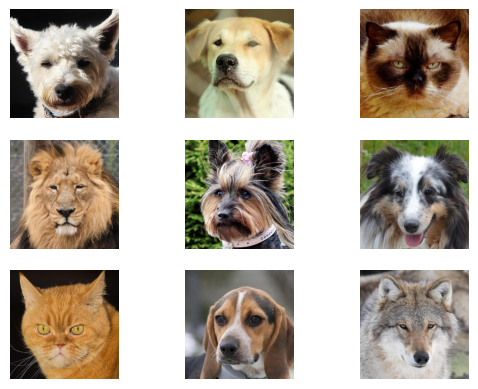

In [114]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
    for col in range(n_cols):
      image = Image.open(data_df.sample(n = 1)['image_paths'].iloc[0]).convert("RGB")
      axarr[row, col].imshow(image)
      axarr[row, col].axis('off')

plt.show()

In [115]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [116]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [117]:
class Net(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1) # First Convolution layer
      self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1) # Second Convolution layer
      self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1) # Third Convolution layer
      self.pooling = nn.MaxPool2d(2,2) # The pooling layer, we will be using the same layer after each conv2d.
      self.relu = nn.ReLU() # ReLU Activation function

      self.flatten = nn.Flatten() # Flatten and vectorize the output feature maps that somes from the final convolution layer.
      self.linear = nn.Linear((128 * 16 * 16), 128) # Traditional Dense (Linear)
      self.output = nn.Linear(128, len(data_df['labels'].unique())) # Output Linear Layer


    def forward(self, x):
      x = self.conv1(x) # -> Outputs: (32, 128, 128)
      x = self.pooling(x)# -> Outputs: (32, 64, 64)
      x = self.relu(x)
      x = self.conv2(x) # -> Outputs: (64, 64, 64)
      x = self.pooling(x) # -> Outputs: (64, 32, 32)
      x = self.relu(x)
      x = self.conv3(x) # -> Outputs: (128, 32, 32)
      x = self.pooling(x) # -> Outputs: (128, 16, 16)
      x = self.relu(x)
      x = self.flatten(x)
      x = self.linear(x)
      x = self.output(x)

      return x


In [118]:
model = Net().to(device)
summary(model, input_size = (3, 128, 128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [119]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [120]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

In [ ]:
for epoch in range(EPOCHS):
  train_acc_train=0
  total_loss_train=0
  total_loss_val=0
  total_acc_val=0

  for inputs,labels in tqdm(train_loader):
    optimizer.zero_grad()

    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  with torch.no_grad():
    for inputs,labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs,labels)
      total_loss_val += val_loss.item()
      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_val_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}
              Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)}''')
  print("="*25)


  6%|▌         | 41/706 [04:33<44:13,  3.99s/it]